In [1]:
import numpy as np
from tensorflow import keras
fashion_mnist = keras.datasets

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import urllib
urllib.request.urlretrieve ("https://gitlab.com/knork/data/raw/e0a833fb698e00db25be29dba89f0b6c6a2efcc8/ORL_faces.npz?inline=false", "face.npz")

data = np.load('face.npz')

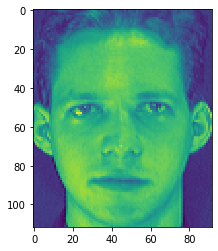

In [2]:
trainX = data['trainX']
trainY = data['trainY']
testX = data['testX']
testY = data['testY']
trainX_check= np.reshape(trainX,(240,112,92))
plt.imshow(trainX_check[0])
plt.show()


import torch
from torch.utils.data import Dataset, TensorDataset    
#y = np.concatenate((trainY,testY))
dataframe = TensorDataset(
    torch.from_numpy(np.concatenate((trainX,testX))).float(),
    torch.from_numpy(np.concatenate((trainY,testY))).type(torch.LongTensor)
)

In [39]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.out = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.softmax(self.out(x),dim=1)
        return x.squeeze()

class MySGD(torch.optim.Optimizer):
  
    def __init__(self, params, lr=1e-4,nestrov_momentum=-1,normilization_rate=0.0,norm=None):
        defaults = dict(lr=lr,momentum=nestrov_momentum,normalization=normilization_rate,norm=norm)
        super(MySGD, self).__init__(params, defaults)    
    # def step(self, closure=None):        
    #     loss = None
    #     if closure is not None:
    #         loss = closure()
    # 
    #     for group in self.param_groups:           
    #         for p in group['params']:
    #             if p.grad is None:
    #                 continue
    #             d_p = p.grad.data
    #             p.data.add_(-group['lr'], d_p)
    # 
    #     return loss
    def step(self, closure=None):        
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:   
            momentum= group['momentum']
            a=group['normalization']
            norm=group['norm']
            lr = group['lr'];
            for p in group['params']:
                if p.grad is None:
                    continue
                dw = p.grad.data
                p.data.add_(-lr,dw)

        
                if norm == 'L2':
                    dw.add_(a,p.data)
                elif norm == 'L1':
                    dw.add_(a,torch.sign(p.data))

                # nestrov
                if momentum>lr:
                    # make sure each parameter (weight) has velocity storage  
                    param_state = self.state[p]
                    if 'velocity' not in param_state:
                        param_state['velocity'] = torch.clone(dw).detach()

                    vel = param_state['velocity']
                    vel.mul_(momentum).add_(-lr,dw) 
                    p.data.add_(vel)
                else:
                    # SGD or batched SGD
                    # add_(self,alpha,other) => self += alpha*other
                    p.data.add_(-lr,dw)
        return loss






def runRegression(optimizer,x,y,test_x,test_y):
    
    losses = []
    val_losses = []    

    total=0
    correct=0            
    with torch.no_grad():
        outputs = model(test_x)
        _, predicted = torch.max(outputs.data, 1)
        total += test_y.shape[0]
        correct += (predicted == test_y).sum().item()
        print('Accuracy before training: %d %%' % (
            100 * correct / total))
  
    for epoch in range(25):
        # Makes predictions
        y_pred = model(x).squeeze()
        # Computes loss
        loss = loss_fn(y_pred,y)
        optimizer.zero_grad()
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        
        losses.append(loss)
        with torch.no_grad():            
            model.eval()
            yhat = model(test_x)
            val_loss = loss_fn( yhat,test_y)
            val_losses.append(val_loss.item())
            
    with torch.no_grad():
        outputs = model(test_x)
        _, predicted = torch.max(outputs.data, 1)
        total += test_y.shape[0]
        correct += (predicted == test_y).sum().item()
        print('Accuracy after training: %d %%' % (
            100 * correct / total))
    
    return (np.array(losses), val_loss)
        
def weights_init_uniform_rule(m):
        classname = m.__class__.__name__
        # for every Linear layer in a model..
        if classname.find('Linear') != -1:
            # get the number of the inputs
            n = m.in_features
            y = 1.0/np.sqrt(n)
            m.weight.data.uniform_(-y, y)
            m.bias.data.fill_(0)


dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
D_in, H, D_out = trainX[0].size, 512, 20


In [40]:
x = torch.from_numpy(trainX).float().to(device)
y = torch.from_numpy(trainY)
y=y.type(torch.LongTensor).to(device)
test_x = torch.from_numpy(testX).float().to(device)
test_y = torch.from_numpy(testY).type(torch.LongTensor).to(device)

model = TwoLayerNet(D_in, H, D_out)
loss_fn = nn.CrossEntropyLoss()

model.apply(weights_init_uniform_rule)
model.to(device)
optimizer = MySGD(model.parameters())
loss1,_ =runRegression(optimizer,x,y,test_x,test_y)

#reset model
model.apply(weights_init_uniform_rule)
model.to(device)
optimizer = MySGD(model.parameters(),nestrov_momentum=0.8)
loss2,_ =runRegression(optimizer,x,y,test_x,test_y)

#reset model
model.apply(weights_init_uniform_rule)
model.to(device)
optimizer = MySGD(model.parameters(),nestrov_momentum=0.8,norm='L2',normilization_rate=0.5)
loss3,_ =runRegression(optimizer,x,y,test_x,test_y)

#reset model
model.apply(weights_init_uniform_rule)
model.to(device)
optimizer = MySGD(model.parameters(),nestrov_momentum=0.8,norm='L1',normilization_rate=0.5)
loss4,_ =runRegression(optimizer,x,y,test_x,test_y)

Accuracy before training: 5 %
Accuracy after training: 7 %
Accuracy before training: 3 %
Accuracy after training: 4 %
Accuracy before training: 5 %
Accuracy after training: 5 %
Accuracy before training: 5 %
Accuracy after training: 6 %


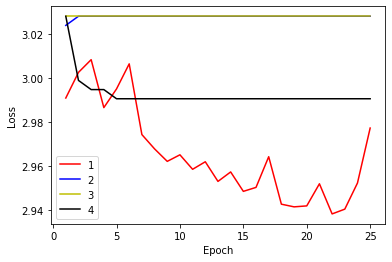

In [41]:
# Plot Everything
epoch_count = range(1, len(loss1) + 1)
plt.plot(epoch_count, loss1, 'r-')
plt.plot(epoch_count, loss2, 'b-')
plt.plot(epoch_count, loss3, 'y-')
plt.plot(epoch_count, loss4, 'k-')
plt.legend(['1', '2','3','4'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();